# 분석 배경

OO 공장의 고객사에서 최근 들어 "Scale 불량 발생 증가"라는 이슈가 발생했다.

그 원인을 분석해 본 결과 압연공정에서 Scale불량이 급증한 것을 확인할 수 있었다.

그래서 데이터를 수집하여 다양한 분석을 통해 불량 발생의 근본 원인을 찾고 결과를 해석하여 개선 기회를 도출한다.

# 분석 현황

발생원인(발생률%) : 압입흠(1.3), Scratch(0.5), 두께 부족(0.4), Scale(0.5), 계(7.2)

# 배경 지식

#### Scale 발생: 열간압연된 coil의 표면에 생성된 산화성 물질로, Scale이 없을 수록 질이 좋은 철강이라고 평가된다. (즉 없을수록 좋다)
#### 가열로 가열대 온도: 예열된 슬라브를 상부온도가 1260°C-1280°C로 유지된 가열대에서 50분-70분 동안 체류시켜 상기 슬라브의 온도를 1130°C-1150°C로 유지하는 단계
#### 가열로 균열대 온도: 가열된 상기 슬라브를 상기 가열로의 균열대에 45분-55분 동안 유지시키는 단계
#### 가열로 추출 온도: 가열로의 균열대로부터 추출되는 상기 슬라브의 추출온도를 1165°C-1185로 유지하는 단계
#### Hot Scale Breaker: 열간상태의 슬래브(Slab) 표면에 생성된 두꺼운 스케일을 제거하기 위한 장치
#### 사상 압연 온도: 상기 균열대에서 추출된 슬라브를 990°C~1010°C에서 조압연하는 단계
#### 압연간 Descaling 횟수: 스케일을 제거하는 단계
#### 판두께: 말 그대로 판의 두께를 의미하는 것

### Scale이 낮을 수록 좋을 것이다.
### 각 단게의 온도는 무조건 낮거나 높다고 좋은 것이 아니라 적절히 조절해야한다.
### Hot scale Breaker는 존재하는 것이 좋다. (스케일 제거를 위함)

In [196]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale,minmax_scale,robust_scale
#%matplotlib inline background 그래프 실행 및 결과 확인
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
#예측
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
#평가함수
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
#모델 성능 평가
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,roc_curve,auc,precision_score,recall_score
#confusion matrix
from sklearn.metrics import confusion_matrix

#Scale 변환:평균,표준편차 기준
from sklearn.preprocessing import StandardScaler
#주성분 분석
from sklearn.decomposition import PCA
#회귀분석
import statsmodels.api as sm
#RMSE:root mean squared error 함수
def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
#MAPE:mean absolute percentage error 함수
def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100
#분류 : KNN
from sklearn.neighbors import KNeighborsClassifier
#로지스틱 회귀
from statsmodels.api import Logit
#데이터 분항
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from IPython.core.display import display, HTML
# 추검정 및 통계 분석 패키지
from scipy import stats
from scipy.stats import shapiro
import scipy.stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from sklearn.linear_model import LinearRegression
display(HTML("<style>.container { width:100% !important; }</style>"))

In [155]:
import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   
#그래프에서 마이너스 기호가 표시되도록 하는 설정입니다. 

In [197]:
df_raw = pd.read_csv("/Users/joylee/Downloads/SCALE불량.csv", engine = 'python', encoding = 'EUC-KR')
df_raw #데이터 불러오기

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,PB563502,2008-08-02:13:35:36,불량,NK-KA,C0,20.14,3580,38639,21870,3호기,...,1172,72,1164,62,245,1164,1005,적용,8,2조
716,PB563503,2008-08-02:13:35:02,양품,NV-A32,C0,15.08,3212,48233,18340,2호기,...,1150,61,1169,61,238,1169,947,적용,10,1조
717,PB563504,2008-08-02:14:40:00,양품,NV-A32,C0,16.60,3441,43688,19590,2호기,...,1169,65,1163,77,247,1163,948,적용,10,4조
718,PB563505,2008-08-02:13:35:19,양품,LR-A,C0,15.59,3363,48740,80240,3호기,...,1179,86,1163,45,243,1163,940,적용,10,2조


In [161]:
df_raw.info() #데이터 정보 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLATE_NO           720 non-null    object 
 1   ROLLING_DATE       720 non-null    object 
 2   SCALE              720 non-null    object 
 3   SPEC               720 non-null    object 
 4   STEEL_KIND         720 non-null    object 
 5   PT_THK             720 non-null    float64
 6   PT_WDTH            720 non-null    int64  
 7   PT_LTH             720 non-null    int64  
 8   PT_WGT             720 non-null    int64  
 9   FUR_NO             720 non-null    object 
 10  FUR_NO_ROW         720 non-null    int64  
 11  FUR_HZ_TEMP        720 non-null    int64  
 12  FUR_HZ_TIME        720 non-null    int64  
 13  FUR_SZ_TEMP        720 non-null    int64  
 14  FUR_SZ_TIME        720 non-null    int64  
 15  FUR_TIME           720 non-null    int64  
 16  FUR_EXTEMP         720 non

In [162]:
df_raw.isnull().sum() #결측치는 없는 것으로 확인되었다.

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

[결측치 및 데이터 확인결과]
- 전체 데이터수는 720개이다.
- 결측치가 존재하지 않는다.
- 목표변수는 scale(이산형: 0과1) , 설명변수(연속형, 20개)
- 문자형 변수를 더미변수로 바꿔주어야 함.(이산형 처리를 위함)
- 탐색적 분석 이후에 더미화 해주기(더미화 해주면 탐색적 분석을 할 수가 없기 때문)
- plate no는 scale 불량과 전혀 상관이 없음 ->  drop
- ROLLING_DATE는 scale 불량과 전혀 상관이 없음 -> drop
- FUR_SZ_TEMP와 FUR_EXTEMP는 값이 같음. -> 둘중 한개 drop


In [163]:
df_raw.describe()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.527778,1149.666667,78.802778,300.563889,1149.666667,933.920833,8.319444
std,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,37.660799,17.571788,36.421004,45.390303,17.571788,107.863887,1.623252
min,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1113.000000,0.000000,5.000000
25%,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1132.000000,889.750000,6.000000
50%,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1155.000000,951.000000,8.000000
75%,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,86.000000,342.000000,1164.000000,994.250000,10.000000
max,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,312.000000,1185.000000,294.000000,398.000000,1185.000000,1078.000000,10.000000


## 불필요한 변수 삭제

In [164]:
df_raw = df_raw.drop(['PLATE_NO'], axis =1)
df_raw = df_raw.drop(['ROLLING_DATE'], axis =1)
df_raw = df_raw.drop(['FUR_EXTEMP'], axis =1)
df_raw = df_raw.drop(['PT_WGT'], axis =1)
df_raw = df_raw.drop(['FUR_HZ_TIME'], axis =1)

In [165]:
df_raw

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,AB/EH32-TM,T1,32.25,3707,15109,1호기,1,1144,1133,59,282,934,적용,8,2조
1,양품,AB/EH32-TM,T1,32.25,3707,15109,1호기,2,1144,1135,53,283,937,적용,8,2조
2,양품,NV-E36-TM,T8,33.27,3619,19181,2호기,1,1129,1121,55,282,889,적용,8,3조
3,양품,NV-E36-TM,T8,33.27,3619,19181,2호기,2,1152,1127,68,316,885,적용,8,3조
4,양품,BV-EH36-TM,T8,38.33,3098,13334,3호기,1,1140,1128,48,314,873,적용,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,불량,NK-KA,C0,20.14,3580,38639,3호기,1,1172,1164,62,245,1005,적용,8,2조
716,양품,NV-A32,C0,15.08,3212,48233,2호기,1,1150,1169,61,238,947,적용,10,1조
717,양품,NV-A32,C0,16.60,3441,43688,2호기,2,1169,1163,77,247,948,적용,10,4조
718,양품,LR-A,C0,15.59,3363,48740,3호기,2,1179,1163,45,243,940,적용,10,2조


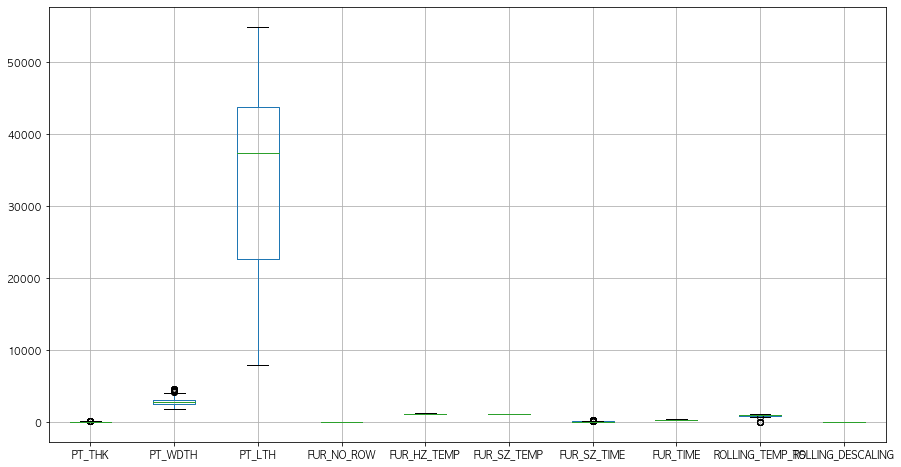

In [166]:
df_raw.boxplot(figsize=(15,8)) #이상치 없음

# 데이터 탐색

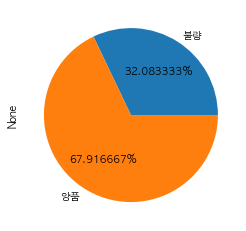

In [167]:
df_count = df_raw.groupby(["SCALE"]).size()
df_count.plot.pie(y="SCALE", autopct="%1f%%")
#불량률은 약 32% 양품은 약 68%

## 히스토그램 출력함수

In [168]:
def fun_plot_hist(data, var):
    plt.hist(data[data['SCALE']=='양품'][var], label = '양품', alpha = 0.5)
    plt.hist(data[data['SCALE']=='불량'][var], label = '불량', alpha = 0.5)
    plt.legend()

## 교차표 출력함수

In [169]:
def fun_print_crosstab(data, var):
    print(pd.crosstab(index = data["SCALE"], columns = data[var]))
    print()
    print(pd.crosstab(index = data["SCALE"], columns = data[var], normalize = "columns").round(3))

## 막대 그래프 출력

In [170]:
def fun_plot_bar(data, var):
    a = data[var].value_counts()
    a.plot.bar()

# 막대그래프 변수 리스트

### 작업조

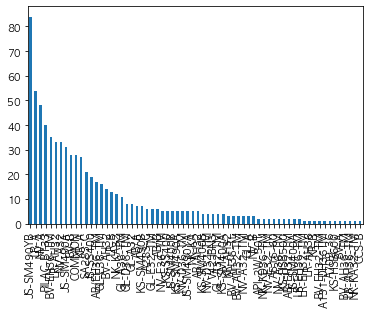

In [171]:
fun_plot_bar(df_raw,"SPEC")

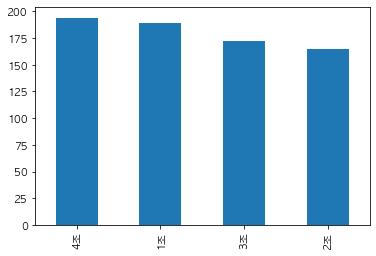

In [172]:
fun_plot_bar(df_raw,"WORK_GR")

# 히스토그램 변수 리스트

### 작업시각

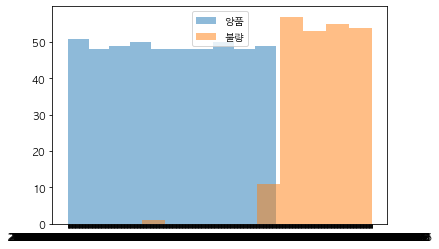

In [198]:
fun_plot_hist(df_raw,"ROLLING_DATE")

- 특정시점 이상부터 불량이 발생하기 시작했음.
- x축이 시간순 배열이 아니므로 의미가 없음 -> drop 

### 강종

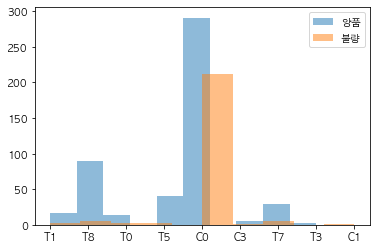

In [24]:
fun_plot_hist(df_raw,"STEEL_KIND")

- C0에서 유독 불량이 많음.

### plate 두께

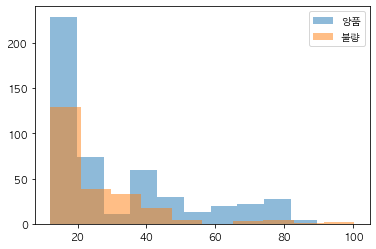

In [100]:
fun_plot_hist(df_raw, 'PT_THK')

- 플레이트의 두께 폭이 작을 수록, 불량이 많다.
- 플레이트의 두께가 작다는 것은 곧 압연을 많이 한다는 뜻이다.
- 압연을 많이 하면 스케일이 많이 발생한다.

### plate 폭

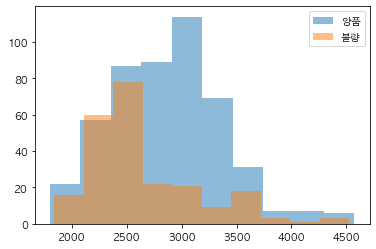

In [101]:
fun_plot_hist(df_raw, "PT_WDTH")

- 플레이트의 폭이 2500 근방까지 불량률이 증가함
- 그러나 그 이후의 불량률이 일정하지 않음.
- x축이 시간 순 배열이 아니므로 의미가 없음 -> drop

### plate 길이

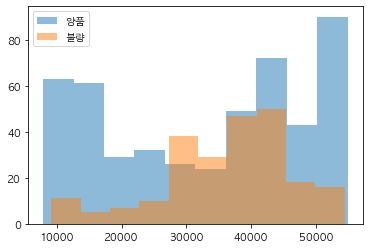

In [102]:
fun_plot_hist(df_raw, "PT_LTH")

- 플레이트의 길이 폭이 30000~45000정도 까지 증가함.
- 그 이후로 급격하게 불량률이 떨어짐.
- 특정 구간에 대한 불량률을 조사해 볼 필요가 있음.

### plate 중량

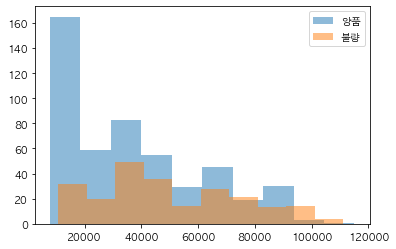

In [103]:
fun_plot_hist(df_raw, "PT_WGT")

- 플레이트의 중량에따라 scale 불량의 비율이 큰 차이가 없는 것으로 보아 두 변수간의 상관이 적다고 생각할 수 있다. 

### 가열로 호기

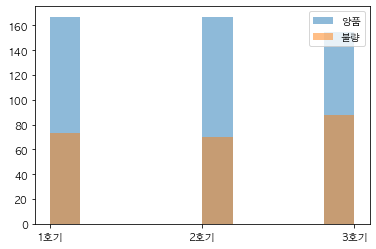

In [104]:
fun_plot_hist(df_raw, "FUR_NO")

- 가열호기에 따라 불량률의 차이는 크지 않다
- 다만, 작업 순번과 같이 확인해야 하는 문제이다.

### 가열로 작업순번

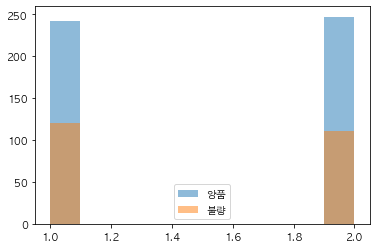

In [105]:
fun_plot_hist(df_raw, "FUR_NO_ROW")

- 작업 순번에 따라 불량률의 차이는 크지 않다
- 다만, 가열로 호기와 같이 확인해야 하는 문제이다.

### 가열로 가열대 온도

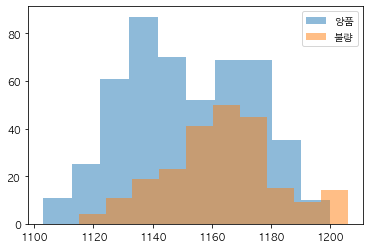

In [106]:
fun_plot_hist(df_raw, "FUR_HZ_TEMP")

- 가열로 온도가 1160도 근처에서 불량률이 높은것으로 보아 scale 불량과 연관 있을것임

### 가열로 가열대 시간

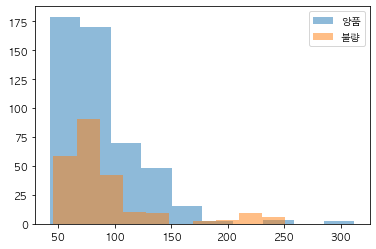

In [107]:
fun_plot_hist(df_raw, "FUR_HZ_TIME")

- 가열로 시간에따라 scale 불량의 변화가 크지않음
- scale 불량과 관계가 적다고 볼 수 있음.

### 가열로 균열대 온도

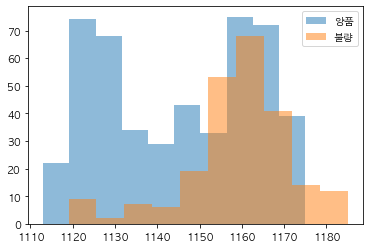

In [108]:
fun_plot_hist(df_raw, "FUR_SZ_TEMP")

- 가열로 균열대 온도가 1150~60 구간의 불량률이 큰것으로 보아 scale 불량과 연관이 있을 것임.

### 가열로 균열대 시간

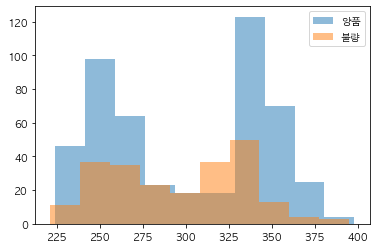

In [109]:
fun_plot_hist(df_raw, "FUR_TIME")

- 불량률이 특정 구간에서 높다. 
-  어느정도 영향이 있을 것으로 보인다.

### 추출온도

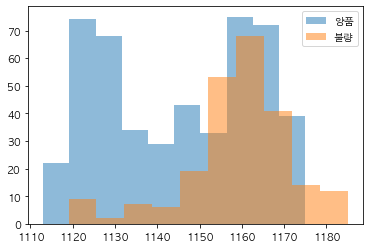

In [112]:
fun_plot_hist(df_raw, "FUR_EXTEMP")

- FUR_SZ_TEMP와 동일한 값을 지녔다.
- 중복 되었으므로 drop 한다.

### 압연온도

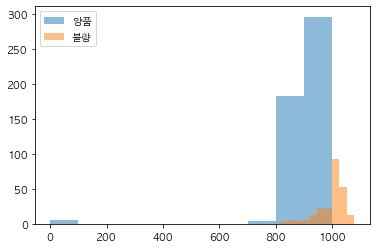

In [36]:
fun_plot_hist(df_raw, "ROLLING_TEMP_T5")

- 특정 구간(800도 이상)에서만 발생한다.
- 스케일 발생과 매우 밀접한 관련이 있다고 볼 수 있다.

### HSB적용 (1 - 적용, 0 - 미적용)

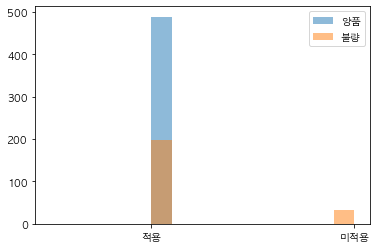

In [37]:
fun_plot_hist(df_raw, "HSB")

- HSB 미적용 제품의 경우 양품이 한개도 존재하지 않는다.
- HSB 적용 제품의 경우 양품이 불량품에 비해 2배이상 많다.
- 스케일 불량에 가장 크리티컬한 요인일 것이라고 예측할 수 있다.

### 압연 중 Descaling 횟수

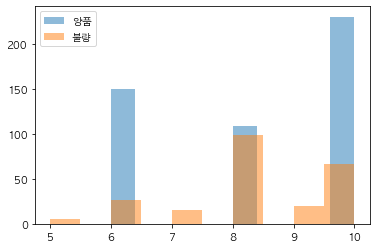

In [38]:
fun_plot_hist(df_raw, "ROLLING_DESCALING")

- Descaling 횟수가 적을 경우 양품이 없고 불량품만 있는 경우가 있다.
- Descaling 횟수가 많을 수록, 양품이 상당히 많다.
- Descaling도 상당히 스케일 불량에 상당히 크리티컬할 요인일 것이다.

### 작업조

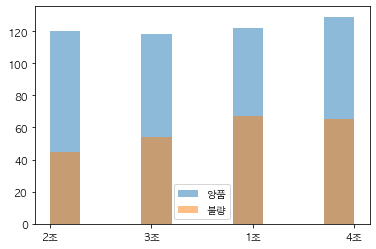

In [39]:
fun_plot_hist(df_raw, "WORK_GR")

- 2조의 불량률이 낮다
- 단 모든 조의 능률은 큰차이가 없다

## 가열로 호기

In [87]:
fun_print_crosstab(df_raw, "FUR_NO") #큰차이 보이지 않음

FUR_NO  1호기  2호기  3호기
SCALE                
불량       73   70   88
양품      167  167  155

FUR_NO    1호기    2호기    3호기
SCALE                      
불량      0.304  0.295  0.362
양품      0.696  0.705  0.638


In [41]:
df_raw[df_raw["SCALE"]=="불량"][df_raw["HSB"]=="적용"].count()

/Users/joylee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


PLATE_NO             198
ROLLING_DATE         198
SCALE                198
SPEC                 198
STEEL_KIND           198
PT_THK               198
PT_WDTH              198
PT_LTH               198
PT_WGT               198
FUR_NO               198
FUR_NO_ROW           198
FUR_HZ_TEMP          198
FUR_HZ_TIME          198
FUR_SZ_TEMP          198
FUR_SZ_TIME          198
FUR_TIME             198
FUR_EXTEMP           198
ROLLING_TEMP_T5      198
HSB                  198
ROLLING_DESCALING    198
WORK_GR              198
dtype: int64

In [42]:
df_raw[df_raw["SCALE"]=="불량"][df_raw["HSB"]=="미적용"].count()

/Users/joylee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


PLATE_NO             33
ROLLING_DATE         33
SCALE                33
SPEC                 33
STEEL_KIND           33
PT_THK               33
PT_WDTH              33
PT_LTH               33
PT_WGT               33
FUR_NO               33
FUR_NO_ROW           33
FUR_HZ_TEMP          33
FUR_HZ_TIME          33
FUR_SZ_TEMP          33
FUR_SZ_TIME          33
FUR_TIME             33
FUR_EXTEMP           33
ROLLING_TEMP_T5      33
HSB                  33
ROLLING_DESCALING    33
WORK_GR              33
dtype: int64

# 로지스틱 회귀분석

In [251]:
df_raw = pd.read_csv("/Users/joylee/Downloads/SCALE불량.csv", engine = 'python', encoding = 'EUC-KR')
df_raw #데이터 불러오기

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,PB563502,2008-08-02:13:35:36,불량,NK-KA,C0,20.14,3580,38639,21870,3호기,...,1172,72,1164,62,245,1164,1005,적용,8,2조
716,PB563503,2008-08-02:13:35:02,양품,NV-A32,C0,15.08,3212,48233,18340,2호기,...,1150,61,1169,61,238,1169,947,적용,10,1조
717,PB563504,2008-08-02:14:40:00,양품,NV-A32,C0,16.60,3441,43688,19590,2호기,...,1169,65,1163,77,247,1163,948,적용,10,4조
718,PB563505,2008-08-02:13:35:19,양품,LR-A,C0,15.59,3363,48740,80240,3호기,...,1179,86,1163,45,243,1163,940,적용,10,2조


In [252]:
df_raw.isnull().sum(axis=0)

df_raw["SCALE"] = np.where(df_raw["SCALE"] == "양품", 0, 1)

df_raw

# train_test_split(데이터, test_size = test 데이터 비율, random_state:랜덤)
df_train, df_test = train_test_split(df_raw, # 데이터
                                    test_size = 0.3, # test 데이터의 비율
                                    random_state = 1234) # random state

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))


train data size : (504, 21)
test data size : (216, 21)


In [253]:
log_model = Logit.from_formula("""SCALE ~ PT_THK + PT_WDTH + PT_LTH  + FUR_HZ_TEMP + FUR_SZ_TEMP + FUR_TIME + ROLLING_TEMP_T5 + C(HSB) + ROLLING_DESCALING""", df_train)
log_result = log_model.fit()
print(log_result.summary())

         Current function value: 0.270654
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      494
Method:                           MLE   Df Model:                            9
Date:                Mon, 17 Feb 2020   Pseudo R-squ.:                  0.5669
Time:                        06:32:48   Log-Likelihood:                -136.41
converged:                      False   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 1.890e-71
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -91.1885   4838.679     -0.019      0.985   -9574.826    9392.449
C(HSB)[T.적용]        -24.2926   4838.631     

/Users/joylee/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [254]:
y_pred = log_result.predict(df_test)
y_pred_class = (y_pred > 0.5).astype(int)
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["SCALE"], y_pred_class)))
print("Confusion Matrix \n{}".format(confusion_matrix(df_test["SCALE"], y_pred_class)))

Accuracy: 0.852

Confusion Matrix 
[[123  22]
 [ 10  61]]


In [255]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
df_char = df_raw.select_dtypes(include = "object")
df_numeric = df_raw.select_dtypes(exclude = "object")

In [249]:
# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

In [225]:
# 문자 데이터 + 숫자 데이터
df_scaled = pd.concat([df_numeric_scaled, df_char], axis=1)
df_scaled

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,PLATE_NO,ROLLING_DATE,SPEC,STEEL_KIND,FUR_NO,HSB,WORK_GR
0,-0.687308,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.949149,-0.544097,...,-0.949149,0.000734,-0.196930,PB562774,2008-08-01:00:00:15,AB/EH32-TM,T1,1호기,적용,2조
1,-0.687308,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.835252,-0.708951,...,-0.835252,0.028567,-0.196930,PB562775,2008-08-01:00:00:16,AB/EH32-TM,T1,1호기,적용,2조
2,-0.687308,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-1.632537,-0.654000,...,-1.632537,-0.416748,-0.196930,PB562776,2008-08-01:00:00:59,NV-E36-TM,T8,2호기,적용,3조
3,-0.687308,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-1.290843,-0.296815,...,-1.290843,-0.453858,-0.196930,PB562777,2008-08-01:00:01:24,NV-E36-TM,T8,2호기,적용,3조
4,-0.687308,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-1.233894,-0.846330,...,-1.233894,-0.565186,-0.196930,PB562778,2008-08-01:00:01:44,BV-EH36-TM,T8,3호기,적용,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1.454951,-0.476916,1.493531,0.312308,-0.792904,-0.994460,0.799021,-0.439164,0.816269,-0.461669,...,0.816269,0.659429,-0.196930,PB563502,2008-08-02:13:35:36,NK-KA,C0,3호기,적용,2조
716,-0.687308,-0.741293,0.782392,1.006578,-0.935621,-0.994460,-0.256038,-0.731448,1.101013,-0.489145,...,1.101013,0.121341,1.036021,PB563503,2008-08-02:13:35:02,NV-A32,C0,2호기,적용,1조
717,-0.687308,-0.661875,1.224921,0.677679,-0.885084,1.005571,0.655149,-0.625163,0.759320,-0.049533,...,0.759320,0.130618,1.036021,PB563504,2008-08-02:14:40:00,NV-A32,C0,2호기,적용,4조
718,-0.687308,-0.714646,1.074191,1.043267,1.566994,1.005571,1.134722,-0.067166,0.759320,-0.928757,...,0.759320,0.056399,1.036021,PB563505,2008-08-02:13:35:19,LR-A,C0,3호기,적용,2조


In [226]:
# BAD 데이터를 0과 1로 변환, np.where(조건, 조건을 만족하는 경우, 만족하지 않는 경우) 
df_numeric_scaled["SCALE"] = np.where(df_numeric_scaled["SCALE"] > 0, 1, 0)
df_scaled = df_numeric_scaled

In [227]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size=0.3, random_state=1234)

In [257]:
scaled_log_model = Logit.from_formula("""SCALE ~ PT_THK + PT_WDTH + PT_LTH + FUR_HZ_TEMP + FUR_SZ_TEMP + FUR_TIME + ROLLING_TEMP_T5 + ROLLING_DESCALING""", df_scaled_train)

In [258]:
scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.359037
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      495
Method:                           MLE   Df Model:                            8
Date:                Mon, 17 Feb 2020   Pseudo R-squ.:                  0.4255
Time:                        06:33:16   Log-Likelihood:                -180.95
converged:                       True   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 2.576e-53
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.4814      0.167     -8.855      0.000      -1.809      -1.153
PT_THK  

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR


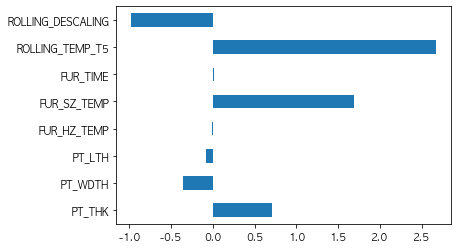

In [259]:
df_log_scaled_coef = pd.DataFrame({"Coef":scaled_log_result.params.values[1:]},
                                 index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef", legend=False)

important=df_raw[df_raw['FUR_EXTEMP']!=df_raw['FUR_SZ_TEMP']]
important


## 더미변수 및 데이터 분할

In [260]:
# drop: X변수와 변수 삭제
df_raw_x = df_raw.drop(["SCALE"], axis=1, inplace=False)
df_raw_y = df_raw["SCALE"]
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_x_dummy = pd.get_dummies(df_raw_x)
df_raw_y = np.where(df_raw_y == "양품", 0, 1)

/Users/joylee/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:252: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [261]:
df_x_dummy
df_raw_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [262]:
# 데이터 분할(train,test 데이터 7:3 비율로 분할)
# train_test_split(x: 설명변수 데이터 )
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_dummy,df_raw_y,test_size=0.3,random_state=1234)
print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(504, 1521)
train data Y size:(504,)
test data X size:(216, 1521)
test data Y size:(216,)


## 의사결정 나무

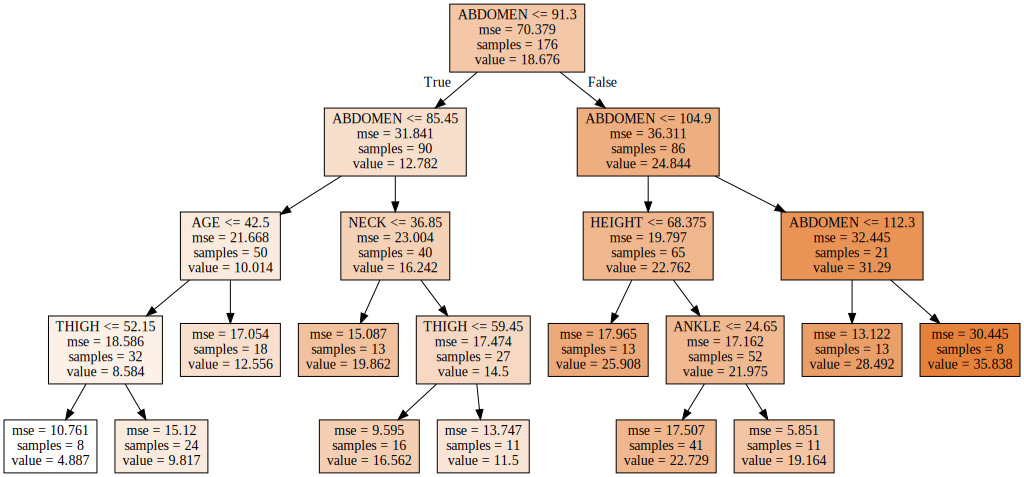

In [267]:
# 최대 깊이 변경에 따른 모델 성능 
# 변수명 저장
v_feature_name=df_train_x.columns
#깊이가 4인 모델 
tree_final=DecisionTreeClassifier(random_state=1234)
tree_final.fit(df_train_x,df_train_y)

#트리 모델을 tree_low.dot 파일로 저장.(목표변수, 0:Good,1:bad)
export_graphviz(tree_final,out_file="tree_low.dot",class_names=["양품","불량"],feature_names=v_feature_name,impurity=True,filled=True)

#graphviz를 이용해 트리 모델 시각화 
with open("tree_final.dot")as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

### 변수중요도

In [199]:
#tree,feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=tree_low.feature_importances_

#df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance=df_importance[df_importance.Importance!=0].round(3)
df_importance

,Feature,Importance
8,ROLLING_TEMP_T5,0.552
89,HSB_적용,0.149
5,FUR_SZ_TEMP,0.117
9,ROLLING_DESCALING,0.095
7,FUR_TIME,0.024
0,PT_THK,0.024
6,FUR_SZ_TIME,0.013
43,SPEC_KR-A,0.007
91,WORK_GR_2조,0.007
93,WORK_GR_4조,0.005


Text(0, 0.5, '설명변수')

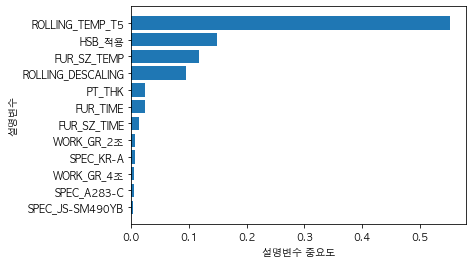

In [136]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
df_importance.sort_values("Importance",ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 랜덤포레스트

In [137]:
rf_final= RandomForestClassifier(random_state=1234)
rf_final.fit(df_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.963


In [201]:
#tree,feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=tree_low.feature_importances_

#df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance=df_importance[df_importance.Importance!=0].round(3)
df_importance




#변수명
v_feature_name=df_train_x.columns
#tree,feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=rf_final.feature_importances_

#df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance=df_importance[df_importance.Importance>=0.05].round(3)
df_importance

,Feature,Importance
8,ROLLING_TEMP_T5,0.293
5,FUR_SZ_TEMP,0.087
0,PT_THK,0.072
9,ROLLING_DESCALING,0.055
1,PT_WDTH,0.055
4,FUR_HZ_TEMP,0.052


Text(0, 0.5, '설명변수')

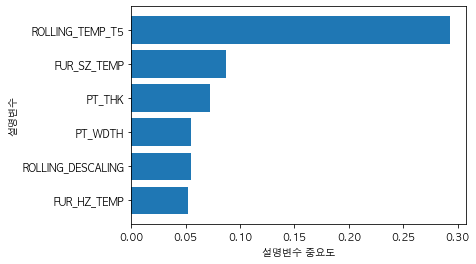

In [202]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
df_importance.sort_values("Importance",ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

# 그래디언트 부스팅

In [140]:
gb_final = GradientBoostingClassifier(random_state=1234)
gb_final.fit(df_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.995


In [204]:
# 변수명 저장 
v_feature_name=df_train_x.columns

#Tree,feature_importances_로 설명변수 중요도 확인 및 테이블로 저장 
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=gb_final.feature_importances_

#df_feature_importance의 테이블을 중요도 별로 정렬
df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance=df_importance[df_importance["Importance"]>0.05].round(3)
df_importance.round(3)

,Feature,Importance
8,ROLLING_TEMP_T5,0.583
5,FUR_SZ_TEMP,0.129
88,HSB_미적용,0.103
9,ROLLING_DESCALING,0.096
89,HSB_적용,0.053


Text(0, 0.5, '변수')

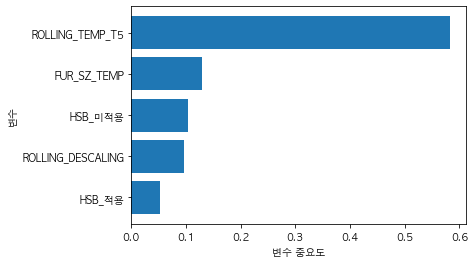

In [270]:
# 5.설명변수의 중요도
#설명 변수 중요도 그래프 
#중요도가 높은 변수를 상위에 그림 
df_importance.sort_values("Importance",ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance['Importance'])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [ ]:
df_odd=[(["ROLLING_DESCALING"]==5)|(["ROLLING_DESCALING"]==7)|(["ROLLING_DESCALING"]==9)]
scale_count=df_odd.groupby(["SCALE"]).size()
scale_count.plot.pie(autopct="%.1f%%")
#UBUNTU에서 작동